In [1]:
%reset -s -f

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.3')
pyro.enable_validation(True)
pyro.set_rng_seed(1)
pyro.enable_validation(True)

In [4]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

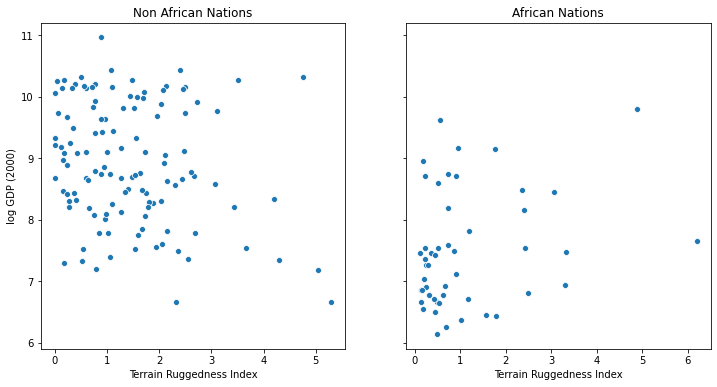

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            non_african_nations["rgdppc_2000"],
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
                african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [6]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [7]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

# Regression model
linear_reg_model = PyroModule[nn.Linear](3, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())


[iteration 0050] loss: 3179.7852
[iteration 0100] loss: 1616.1375
[iteration 0150] loss: 1109.4119
[iteration 0200] loss: 833.7546
[iteration 0250] loss: 637.5822
[iteration 0300] loss: 488.2654
[iteration 0350] loss: 376.4651
[iteration 0400] loss: 296.0484
[iteration 0450] loss: 240.6141
[iteration 0500] loss: 203.9386
[iteration 0550] loss: 180.6171
[iteration 0600] loss: 166.3494
[iteration 0650] loss: 157.9457
[iteration 0700] loss: 153.1786
[iteration 0750] loss: 150.5735
[iteration 0800] loss: 149.2020
[iteration 0850] loss: 148.5065
[iteration 0900] loss: 148.1668
[iteration 0950] loss: 148.0070
[iteration 1000] loss: 147.9347
[iteration 1050] loss: 147.9032
[iteration 1100] loss: 147.8900
[iteration 1150] loss: 147.8848
[iteration 1200] loss: 147.8827
[iteration 1250] loss: 147.8819
[iteration 1300] loss: 147.8817
[iteration 1350] loss: 147.8816
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
Learned parameters:
weight [[-1.94785

In [8]:
from pyro.nn import PyroSample


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [9]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

In [10]:
from pyro.infer import SVI, Trace_ELBO
adam = pyro.optim.AdamW({"lr": 0.1})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [11]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))


[iteration 0001] loss: 6.2310
[iteration 0101] loss: 3.0857
[iteration 0201] loss: 1.4532
[iteration 0301] loss: 1.4656
[iteration 0401] loss: 1.4658
[iteration 0501] loss: 1.4618
[iteration 0601] loss: 1.4717
[iteration 0701] loss: 1.4594
[iteration 0801] loss: 1.5042
[iteration 0901] loss: 1.4646
[iteration 1001] loss: 1.4783
[iteration 1101] loss: 1.4696
[iteration 1201] loss: 1.4751
[iteration 1301] loss: 1.4779
[iteration 1401] loss: 1.4672


In [12]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2085, -1.7068, -0.1347,  0.3600,  9.1465])
AutoDiagonalNormal.scale tensor([0.0593, 0.1313, 0.0347, 0.0653, 0.0513])


In [13]:
guide.quantiles([0.5])

{'sigma': [tensor(0.9899)],
 'linear.weight': [tensor([[-1.7068, -0.1347,  0.3600]])],
 'linear.bias': [tensor([9.1465])]}

In [14]:
dir(guide)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_cond_indep_stacks',
 '_create_plates',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_init_loc',
 '_init_scale',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_loc_scale',
 '_model',
 '_modules',
 '_named_members',
 '_parameters',
 '_prototype_frames',
 '_pyro_context',
 '_pyro_get_fullname',
 '_pyro_name',
 '_pyro_params',
 '_pyro_samples',
 '_pyro_set_supermodule',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_setup_prototy

In [15]:
list(guide.named_pyro_params())

[('loc',
  Parameter containing:
  tensor([-2.2085, -1.7068, -0.1347,  0.3600,  9.1465])),
 ('scale', tensor([0.0593, 0.1313, 0.0347, 0.0653, 0.0513]))]

In [16]:
dict(pyro.get_param_store())

{'AutoDiagonalNormal.loc': Parameter containing:
 tensor([-2.2085, -1.7068, -0.1347,  0.3600,  9.1465]),
 'AutoDiagonalNormal.scale': tensor([0.0593, 0.1313, 0.0347, 0.0653, 0.0513])}

In [17]:
cloudy = torch.distributions.Bernoulli(0.3).sample()
cloudy


tensor(1.)

In [18]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

# enable validation (e.g. validate parameters of distributions)
assert pyro.__version__.startswith('1.3')
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(torch.tensor(1.0))
for _ in range(4):
    data.append(torch.tensor(0.0))

def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(10.0)
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

def guide(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

....................
based on the data and our prior belief, the fairness of the coin is 0.536 +- 0.090


In [19]:
data


[tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.)]

In [22]:
import os
import torch
import torch.distributions.constraints as constraints
import pyro
import pyro.distributions as dist
# Pyro also has a reparameterized Beta distribution so we import
# the non-reparameterized version to make our point
from pyro.distributions.testing.fakes import NonreparameterizedBeta
import pyro.optim as optim
from pyro.infer import SVI, TraceGraph_ELBO
import sys

# enable validation (e.g. validate parameters of distributions)
assert pyro.__version__.startswith('1.3')
pyro.enable_validation(True)

# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
max_steps = 2 if smoke_test else 10000


def param_abs_error(name, target):
    return torch.sum(torch.abs(target - pyro.param(name))).item()


class BernoulliBetaExample:
    def __init__(self, max_steps):
        # the maximum number of inference steps we do
        self.max_steps = max_steps
        # the two hyperparameters for the beta prior
        self.alpha0 = 10.0
        self.beta0 = 10.0
        # the dataset consists of six 1s and four 0s
        self.data = torch.zeros(10)
        self.data[0:6] = torch.ones(6)
        self.n_data = self.data.size(0)
        # compute the alpha parameter of the exact beta posterior
        self.alpha_n = self.data.sum() + self.alpha0
        # compute the beta parameter of the exact beta posterior
        self.beta_n = - self.data.sum() + torch.tensor(self.beta0 + self.n_data)
        # initial values of the two variational parameters
        self.alpha_q_0 = 15.0
        self.beta_q_0 = 15.0

    def model(self, use_decaying_avg_baseline):
        # sample `latent_fairness` from the beta prior
        f = pyro.sample("latent_fairness", dist.Beta(self.alpha0, self.beta0))
        # use plate to indicate that the observations are
        # conditionally independent given f and get vectorization
        with pyro.plate("data_plate"):
            # observe all ten datapoints using the bernoulli likelihood
            pyro.sample("obs", dist.Bernoulli(f), obs=self.data)

    def guide(self, use_decaying_avg_baseline):
        # register the two variational parameters with pyro
        alpha_q = pyro.param("alpha_q", torch.tensor(self.alpha_q_0),
                             constraint=constraints.positive)
        beta_q = pyro.param("beta_q", torch.tensor(self.beta_q_0),
                            constraint=constraints.positive)
        # sample f from the beta variational distribution
        baseline_dict = {'use_decaying_avg_baseline': use_decaying_avg_baseline,
                         'baseline_beta': 0.90}
        # note that the baseline_dict specifies whether we're using
        # decaying average baselines or not
        pyro.sample("latent_fairness", NonreparameterizedBeta(alpha_q, beta_q),
                    infer=dict(baseline=baseline_dict))

    def do_inference(self, use_decaying_avg_baseline, tolerance=0.80):
        # clear the param store in case we're in a REPL
        pyro.clear_param_store()
        # setup the optimizer and the inference algorithm
        optimizer = optim.Adam({"lr": .0005, "betas": (0.93, 0.999)})
        svi = SVI(self.model, self.guide, optimizer, loss=TraceGraph_ELBO())
        print("Doing inference with use_decaying_avg_baseline=%s" % use_decaying_avg_baseline)

        # do up to this many steps of inference
        for k in range(self.max_steps):
            svi.step(use_decaying_avg_baseline)
            if k % 100 == 0:
                print('.', end='')
                sys.stdout.flush()

            # compute the distance to the parameters of the true posterior
            alpha_error = param_abs_error("alpha_q", self.alpha_n)
            beta_error = param_abs_error("beta_q", self.beta_n)

            # stop inference early if we're close to the true posterior
            if alpha_error < tolerance and beta_error < tolerance:
                break

        print("\nDid %d steps of inference." % k)
        print(("Final absolute errors for the two variational parameters " +
               "were %.4f & %.4f") % (alpha_error, beta_error))

# do the experiment
bbe = BernoulliBetaExample(max_steps=max_steps)
bbe.do_inference(use_decaying_avg_baseline=True)
bbe.do_inference(use_decaying_avg_baseline=False)



Doing inference with use_decaying_avg_baseline=True
..
Did 128 steps of inference.
Final absolute errors for the two variational parameters were 0.7990 & 0.7997
Doing inference with use_decaying_avg_baseline=False
....
Did 394 steps of inference.
Final absolute errors for the two variational parameters were 0.7947 & 0.7989


In [27]:
loc = 0.   # mean zero
scale = 1. # unit variance
normal = torch.distributions.Normal(loc, scale) # create a normal distribution object
y = normal.rsample() # draw a sample from N(0,1)
print("sample", x)
print("log prob", normal.log_prob(x)) # score the sample from N(0,1)


sample tensor(-0.1185)
log prob tensor(-0.9260)


In [28]:
pyro.sample("my_sample", pyro.distributions.Normal(loc, scale), obs=torch.tensor([y]))

/Users/psyphh/PycharmProjects/tip/venv/lib/python3.7/site-packages/pyro/primitives.py:86: RuntimeWarning: trying to observe a value outside of inference at my_sample
  RuntimeWarning)


tensor([-0.3521])